### Specific Test III. Learning Mass of Dark Matter Halo (Method - Self Supervised (contrastive loss) Representational Learning using Equivariant Transformers using)

#### **Name:** Yashwardhan Deshmukh [yaashwardhan@gmail.com](mailto:yaashwardhan@gmail.com)

---

**Task:** Using the provided dataset implement a regression algorithm to learn the mapping between lensing images and the lensing dark matter halo mass. You can use the machine learning algorithm of your choice.  Please implement your approach in PyTorch or Keras and discuss your strategy.	

**Dataset:** https://drive.google.com/file/d/1hu472ALwGPBcTCXSAM0VoCWmTktg9j-j/view

**Dataset Description:** The data set consists of strong lensing images for cold dark matter with subhalo substructure. For each lensing image the corresponding fraction of mass in dark matter substructure is provided.

**Evaluation Metrics:** MSE (mean squared error)

--- 

*Trained model for this task can be found in the respective folder in [HERE](https://drive.google.com/drive/folders/1x5gm4ywOQ8brxMn11KjLBxsehQuxtx19?usp=sharing)*

**Strategy**: Equivariant Transformers are custom neural networks that ensure that the learned representations are equivariant to augmentations like rotations, where traditional networks struggle to some extent. 

Here is the strategy in detail: 
*   We can start off by implementing an Equivariant Transformer architecture that consists of a series of custom RotationalConv2D layers which are designed such that they maintain equivariance with respect to rotations of the input. Then a convolution is applied to the rotated versions of the input and combines the resulting feature maps by element-wise addition. We also use ResNet50 weights for transfer learnings to learn the representations faster.
*   For the loss function, we use contrastive loss, which encourages the model to learn embeddings that are closer for images that are similar and apart for images that are different. Basically we do -> the sum of squared distances between positive pairs (y_true = 1) and the squared hinge loss between negative pairs (y_true = 0) with a margin. 
*   Post the training of the embedding model, we finetune the model for our regession task

**Results:** MSE = 2.28 x 10^-4

| Ground Truth | Predicted |
|--------------|-----------|
| 0.045180     | 0.044765  |
| 0.057833     | 0.042786  |
| 0.016935     | 0.045091  |
| 0.047984     | 0.044708  |
| 0.027886     | 0.044014  |
| ...          | ...       |
| 0.041667     | 0.046901  |
| 0.059420     | 0.046184  |


In [8]:
!pip install tensorflow-addons
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import Sequence
import pandas as pd
import keras.backend as K
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, Reshape, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, BatchNormalization, ReLU, Input, Lambda, MultiHeadAttention, LayerNormalization, Layer
from keras.models import Model
from keras.optimizers import Adam
import tensorflow as tf
from keras import layers, Model, Input
from keras.layers import Conv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Input, Lambda, Dense
from keras import backend as K
from keras.losses import cosine_similarity

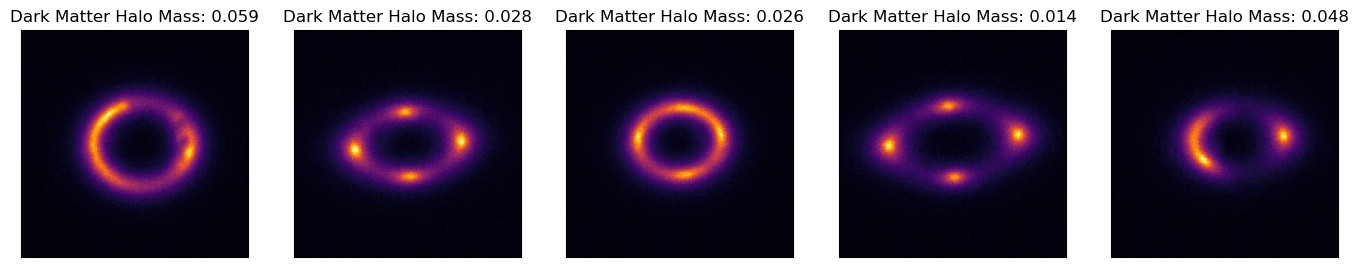

In [11]:
dir_path = 'lens_data'

file_names = os.listdir(dir_path)
fig, axs = plt.subplots(1, 5, figsize=(17, 10))
for i in range(5):
    file_path = os.path.join(dir_path, file_names[i])
    data = np.load(file_path, allow_pickle=True)
    axs[i].imshow(data[0], cmap='inferno')
    axs[i].set_title('Dark Matter Halo Mass: {:.3f}'.format(data[1]), fontsize=12)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.show()

In [12]:
class LensDataGenerator(Sequence):
    def __init__(self, dir_path, file_names, batch_size=32, shuffle=True):
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.file_names = file_names
        self.indexes = np.arange(len(self.file_names))
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.file_names) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_file_names = [self.file_names[i] for i in batch_indexes]
        
        batch_data = []
        for file_name in batch_file_names:
            file_path = os.path.join(self.dir_path, file_name)
            data = np.load(file_path, allow_pickle=True)
            batch_data.append((data[0], data[1]))
        
        batch_x = np.array([data[0] for data in batch_data])
        batch_y = np.array([data[1] for data in batch_data])
        
        return batch_x, batch_y
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


file_names = os.listdir(dir_path)

train_files, val_files = train_test_split(file_names, test_size=0.2)
batch_size=64

train_generator = LensDataGenerator(dir_path, file_names=train_files, batch_size=batch_size, shuffle=True)
val_generator = LensDataGenerator(dir_path, file_names=val_files, batch_size=batch_size, shuffle=True)
steps_per_epoch = len(train_files) // batch_size
validation_steps = len(val_files) // batch_size

In [13]:
x,y = (train_generator).__getitem__(0)
print('Image Array: \n', x[0],'\n\nCorresponding Matter Halo Mass: ', y[0])

Image Array: 
 [[34 29 23 ... 31 30 34]
 [27 23 31 ... 20 36 45]
 [26 22 25 ... 26 35 33]
 ...
 [32 36 30 ... 31 26 46]
 [27 37 33 ... 38 30 19]
 [20 28 26 ... 33 38 39]] 

Corresponding Matter Halo Mass:  0.07472380160706586


In [14]:
class GroupEquivariantConv2D(tf.keras.layers.Layer):
    def __init__(self, num_filters, kernel_size, padding='same', **kwargs):
        super(GroupEquivariantConv2D, self).__init__(**kwargs)
        self.conv = tf.keras.layers.Conv2D(num_filters, kernel_size, padding=padding)

    def call(self, inputs):
        rotated_inputs = [inputs]
        for _ in range(3):
            rotated_inputs.append(tf.image.rot90(rotated_inputs[-1]))

        conv_outputs = []
        for rotated_input in rotated_inputs:
            conv_outputs.append(self.conv(rotated_input))

        output = tf.math.add_n(conv_outputs)
        return output

In [15]:
class EquivariantTransformer(tf.keras.layers.Layer):
    def __init__(self, num_filters, kernel_size, num_heads, **kwargs):
        super(EquivariantTransformer, self).__init__(**kwargs)
        self.conv1 = GroupEquivariantConv2D(num_filters, kernel_size, padding='same')
        self.bn1 = BatchNormalization()
        self.relu1 = ReLU()
        self.conv2 = GroupEquivariantConv2D(num_filters * 2, kernel_size, padding='same')
        self.bn2 = BatchNormalization()
        self.relu2 = ReLU()
        self.conv3 = GroupEquivariantConv2D(num_filters * 4, kernel_size, padding='same')
        self.bn3 = BatchNormalization()
        self.relu3 = ReLU()
        self.self_attention1 = MultiHeadAttention(num_heads=num_heads, key_dim=num_filters * 2)
        self.self_attention2 = MultiHeadAttention(num_heads=num_heads, key_dim=num_filters * 4)
        self.pooling = GlobalAveragePooling2D()

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        y = self.self_attention1(query=x, key=x, value=x)
        x = tf.add(x, y)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        y = self.self_attention2(query=x, key=x, value=x)
        x = tf.add(x, y)

        x = self.pooling(x)
        return x

In [16]:
def contrastive_loss(y_true, y_pred, margin=1.0):
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

In [17]:
input_layer = Input(shape=(150, 150, 1))

backbone = tf.keras.applications.ResNet50(input_tensor=input_layer, include_top=False, weights=None)

equivariant_transformer = EquivariantTransformer(num_filters=128, kernel_size=3, num_heads=2)

embedding_layer = Dense(150)

backbone_output = backbone.output

transformed_output = equivariant_transformer(backbone_output)

embeddings = embedding_layer(transformed_output)

model = Model(inputs=input_layer, outputs=embeddings)

In [18]:
model.compile(optimizer='adam', loss=contrastive_loss)

In [19]:
model.fit(train_generator,steps_per_epoch=steps_per_epoch, validation_data=val_generator, validation_steps=validation_steps, epochs=5)

Epoch 1/5
250/250 [==============================] - 168s 461ms/step - loss: 0.0542 - val_loss: 0.0484
Epoch 2/5
250/250 [==============================] - 116s 465ms/step - loss: 0.0400 - val_loss: 0.0405
Epoch 3/5
250/250 [==============================] - 116s 464ms/step - loss: 0.0400 - val_loss: 0.0406
Epoch 4/5
250/250 [==============================] - 116s 464ms/step - loss: 0.0400 - val_loss: 0.0405
Epoch 5/5
250/250 [==============================] - 116s 464ms/step - loss: 0.0400 - val_loss: 0.0406


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpoint = ModelCheckpoint("sub_structure_classifier_checkpoint.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7)
additional_layers1 = Dense(128)(transformed_output)
additional_layers2 = Dense(64)(additional_layers1)
regression_model = Dense(1)(additional_layers2)
finetune_model = Model(inputs=input_layer, outputs=regression_model)
finetune_model.compile(optimizer='adam', loss='mean_squared_error')
finetune_model.fit(train_generator,steps_per_epoch=steps_per_epoch, validation_data=val_generator, validation_steps=validation_steps, epochs=10, callbacks=[checkpoint, reduce_lr])

Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: 0.1140
Epoch 1: val_loss improved from inf to 0.00053, saving model to dark_matter_regressor_checkpoint.h5
250/250 [==============================] - 160s 478ms/step - loss: 0.1140 - val_loss: 5.2853e-04 - lr: 0.0010
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 3.1310e-04
Epoch 2: val_loss improved from 0.00053 to 0.00031, saving model to dark_matter_regressor_checkpoint.h5
250/250 [==============================] - 115s 461ms/step - loss: 3.1310e-04 - val_loss: 3.0651e-04 - lr: 0.0010
Epoch 3/10
250/250 [==============================] - ETA: 0s - loss: 3.2285e-04
Epoch 3: val_loss did not improve from 0.00031
250/250 [==============================] - 114s 455ms/step - loss: 3.2285e-04 - val_loss: 6.1678e-04 - lr: 0.0010
Epoch 4/10
250/250 [==============================] - ETA: 0s - loss: 3.5891e-04
Epoch 4: val_loss improved from 0.00031 to 0.00024, saving model to dark_matter_regressor_c

In [ ]:
import keras
checkpoint_model = keras.models.load_model('sub_structure_classifier_checkpoint.h5', custom_objects = {'EquivariantTransformer': EquivariantTransformer}, compile=False)

y_true = []
y_pred = []

for i in range(len(val_generator)):
    X_batch, y_batch = val_generator[i]
    y_true.extend(y_batch)
    y_pred.extend(checkpoint_model.predict(X_batch))

y_true = np.array(y_true)
y_pred = np.array(y_pred).squeeze()

In [24]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_true, y_pred)
print("MSE:", mse)

MSE: 0.0002286795264337503


In [26]:
df = pd.DataFrame({'Ground Truth': y_true, 'Predicted': y_pred})
df

,Ground Truth,Predicted
0,0.045180,0.044765
1,0.057833,0.042786
2,0.016935,0.045091
3,0.047984,0.044708
4,0.027886,0.044014
...,...,...
3995,0.034453,0.043580
3996,0.025960,0.045601
3997,0.033596,0.044317
3998,0.041667,0.046901
